In [120]:
# Import modules
import numpy as np
import pandas as pd
import quandl
from itertools import combinations
from datetime import datetime
from datetime import timedelta


from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# Plotting preferences
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
import re

In [2]:
#Reading tags data
tags = pd.read_csv('ml-20m/tags.csv',engine='python')

#Reading ratings data
ratings = pd.read_csv('ml-20m/ratings.csv',engine='python')

#Reading movies data
movies = pd.read_csv('ml-20m/movies.csv', engine='python')

#Reading links data
links = pd.read_csv('ml-20m/links.csv',low_memory=False)

#Reading genome-scores data
tagscore = pd.read_csv('ml-20m/genome-scores.csv',low_memory=False)

#Reading genome-tags data
genome_tag = pd.read_csv('ml-20m/genome-tags.csv',low_memory=False)


In [3]:
print "Tags Info\n"
tags.info()

print "\nRatings Info\n"
ratings.info()

print "\n Tag Scores Info\n"
tagscore.info()


Tags Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 4 columns):
userId       465564 non-null int64
movieId      465564 non-null int64
tag          465548 non-null object
timestamp    465564 non-null int64
dtypes: int64(3), object(1)
memory usage: 14.2+ MB

Ratings Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 610.4 MB

 Tag Scores Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
movieId      int64
tagId        int64
relevance    float64
dtypes: float64(1), int64(2)
memory usage: 268.0 MB


In [4]:
#Checking if there are any null values in the dataframe 
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [5]:
links.isnull().sum()

movieId      0
imdbId       0
tmdbId     252
dtype: int64

In [6]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

No NULL values found in either ratings, links or movies dataframes

In [7]:
ratings.shape

(20000263, 4)

In [8]:
movies.shape

(27278, 3)

In [9]:
tags.shape

(465564, 4)

In [10]:
tags.isnull().sum()

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

In [11]:
tags[tags.tag.isnull()].head()

,userId,movieId,tag,timestamp
373276,116460,123,NaN,1199450867
373277,116460,346,NaN,1199451946
373281,116460,1184,NaN,1199452261
373288,116460,1785,NaN,1199452006
373289,116460,2194,NaN,1199450677


In [12]:
#Dropping any null tags
tags=tags.dropna()
tags.shape

(465548, 4)

Since the tags dataset consisted of 16 null values, we just drop those rows 

In [18]:
# Only keeping the movie id and title from the movies dataframe
movies = movies.loc[:,["movieId","title"]]
movies.head(5)

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [17]:
# The ratings dataframe contains a timestamp column, which is not informative for our purpose.
# So we will go ahead and only keep colums - userid, movieid and rating
ratings = ratings.loc[:,["userId","movieId","rating"]]
ratings.head(5)

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [16]:
# the tags dataframe contains a timestamp column, which is not informative for our purpose.
#So we will go ahead and only keep colums - userid, movieid and tag
tags = tags.loc[:,["userId","movieId","tag"]]
tags.head(5)

,userId,movieId,tag
0,18,4141,Mark Waters
1,65,208,dark hero
2,65,353,dark hero
3,65,521,noir thriller
4,65,592,dark hero


In [19]:
# we now merge the ratings and tags dataframes
data = pd.merge(ratings,tags)

In [20]:
# let us merge this "data" dataframe with the movies dataframe to get the title of the movie
df = pd.merge(data,movies)

In [21]:
df.head()

,userId,movieId,rating,tag,title
0,65,27866,4.0,New Zealand,In My Father's Den (2004)
1,20520,27866,4.0,amazing ending,In My Father's Den (2004)
2,20520,27866,4.0,boring beginning,In My Father's Den (2004)
3,53931,27866,3.5,annoying,In My Father's Den (2004)
4,71833,27866,3.5,Matthew Macfadyen,In My Father's Den (2004)


In [22]:
# Tags for genres
movies_tags = movies.loc[:,["movieId","title"]]

#merge on columns (default join is inner)
movies_tags = pd.merge(tags, movies_tags, on =['movieId'])


title_tags = movies_tags.loc[:,["title","tag"]]


In [23]:
movies_tags.head()

,userId,movieId,tag,title
0,18,4141,Mark Waters,Head Over Heels (2001)
1,66193,4141,naive,Head Over Heels (2001)
2,70201,4141,Mark Waters,Head Over Heels (2001)
3,89274,4141,Freddie Prinze Jr.,Head Over Heels (2001)
4,65,208,dark hero,Waterworld (1995)


In [24]:
#Converting all tags to lower case
df['tag'] = df['tag'].str.lower()

In [25]:
df.corr()

,userId,movieId,rating
userId,1.000000,-0.022822,-0.010542
movieId,-0.022822,1.000000,-0.112277
rating,-0.010542,-0.112277,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1181aef10>]], dtype=object)

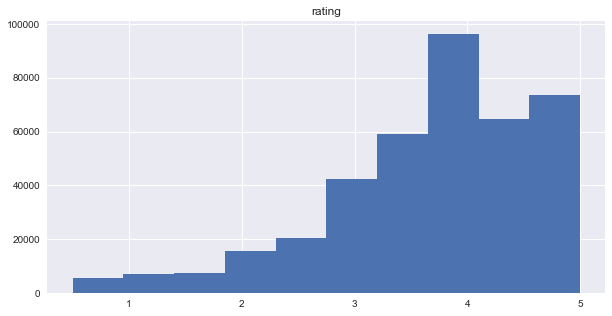

In [26]:
#Viszulaizing the ratings 

df.hist(column='rating', figsize=(10,5))

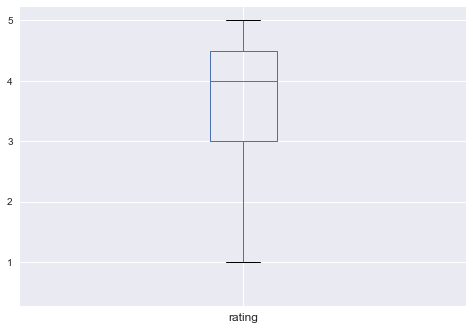

In [27]:
df.boxplot(column='rating', figsize=(10,5), return_type='axes')

The box plot and bar graph show us that most of the user ratings are within the range of 3.5-5.0

In [28]:
# Counting the tags
tag_counts = df['tag'].value_counts()

In [29]:
tag_counts.head(10)

sci-fi             3475
atmospheric        3020
action             2829
comedy             2791
surreal            2456
based on a book    2347
twist ending       2320
funny              2189
dystopia           1941
quirky             1935
Name: tag, dtype: int64

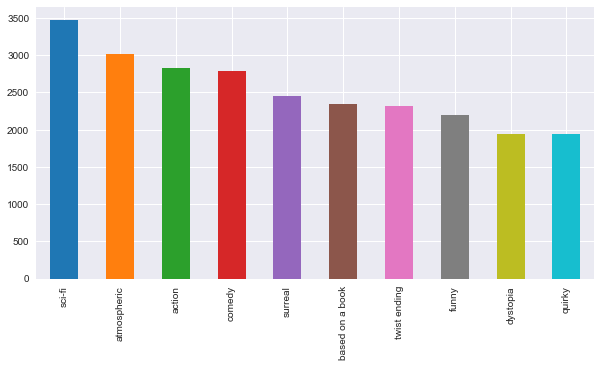

In [30]:
my_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
tag_counts[:10].plot(kind='bar', figsize=(10,5),color=my_colors)

The above bar graph depicts the top 10 tags occuring in all movies. It can be seen that they are- sci-fi, atmospheric, action, comedy, surreal, based on a book, twist ending, funny, dystopia and quirky

In [31]:
#counting the mean rating for each movie
avg_ratings= df.groupby('movieId', as_index=False).mean()
del avg_ratings['userId']
avg_ratings.head()

,movieId,rating
0,1,3.908333
1,2,3.562500
2,3,2.928571
3,4,2.800000
4,5,2.761905


In [32]:
#Counting the total number of ratings by all users to every movie
movie_count = df[['movieId','rating']].groupby('movieId').count()
movie_count.head()

,rating
movieId,
1,420
2,120
3,14
4,5
5,21


In [33]:
#Number of user ratings per movie 
userRatings=df[['movieId','userId']].groupby('movieId',as_index=False).count().rename(columns={'userId':'numberOfUserRatings'})
userRatings.head()

,movieId,numberOfUserRatings
0,1,420
1,2,120
2,3,14
3,4,5
4,5,21


In [34]:
#Using the genome scores and tags data to get the relevance score of the tags
tags_in_movies  = pd.merge(tagscore, genome_tag, on='tagId')[['movieId', 'tag', 'relevance']]

In [35]:
tags_in_movies.head()

,movieId,tag,relevance
0,1,007,0.02500
1,2,007,0.03975
2,3,007,0.04350
3,4,007,0.03725
4,5,007,0.04200


In [36]:
# Since the dataset consists of 20M records, we need to filter out rows that are not useful for our exploration
# let us look at the tag relevance scores to determine a good cut-off

tagscore.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [37]:
#Using a pivot table with index as movie id, columns as the tag id's. The values in the table are the relevance scores
tagscore[:100000].pivot(index='movieId', columns='tagId')['relevance'].head()

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02500,0.02500,0.05775,0.09675,0.14675,0.21700,0.06700,0.26275,0.26200,0.03200,...,0.03950,0.01800,0.04575,0.03275,0.12500,0.04150,0.01925,0.03625,0.07775,0.02300
2,0.03975,0.04375,0.03775,0.04800,0.11025,0.07250,0.04775,0.10975,0.09925,0.02050,...,0.04175,0.01925,0.01725,0.02425,0.12550,0.02250,0.01550,0.01475,0.09025,0.01875
3,0.04350,0.05475,0.02800,0.07700,0.05400,0.06850,0.05600,0.18500,0.04925,0.02675,...,0.04150,0.02675,0.02775,0.03425,0.15550,0.03675,0.01700,0.01950,0.09700,0.01850
4,0.03725,0.03950,0.03675,0.03100,0.06825,0.04050,0.02325,0.08700,0.05125,0.03025,...,0.05750,0.03375,0.02275,0.03975,0.18525,0.05925,0.01500,0.01525,0.06450,0.01300
5,0.04200,0.05275,0.05925,0.03675,0.07525,0.12525,0.02850,0.08500,0.02950,0.02875,...,0.04250,0.02825,0.02150,0.02600,0.14275,0.02075,0.01650,0.01675,0.10750,0.01825


In [38]:
#Creating a new table with the mean relevance scores
table = tagscore[:100000].pivot_table('relevance', index='movieId', columns='tagId', aggfunc='mean')

In [39]:
table.head()

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02500,0.02500,0.05775,0.09675,0.14675,0.21700,0.06700,0.26275,0.26200,0.03200,...,0.03950,0.01800,0.04575,0.03275,0.12500,0.04150,0.01925,0.03625,0.07775,0.02300
2,0.03975,0.04375,0.03775,0.04800,0.11025,0.07250,0.04775,0.10975,0.09925,0.02050,...,0.04175,0.01925,0.01725,0.02425,0.12550,0.02250,0.01550,0.01475,0.09025,0.01875
3,0.04350,0.05475,0.02800,0.07700,0.05400,0.06850,0.05600,0.18500,0.04925,0.02675,...,0.04150,0.02675,0.02775,0.03425,0.15550,0.03675,0.01700,0.01950,0.09700,0.01850
4,0.03725,0.03950,0.03675,0.03100,0.06825,0.04050,0.02325,0.08700,0.05125,0.03025,...,0.05750,0.03375,0.02275,0.03975,0.18525,0.05925,0.01500,0.01525,0.06450,0.01300
5,0.04200,0.05275,0.05925,0.03675,0.07525,0.12525,0.02850,0.08500,0.02950,0.02875,...,0.04250,0.02825,0.02150,0.02600,0.14275,0.02075,0.01650,0.01675,0.10750,0.01825


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1183f0dd0>]], dtype=object)

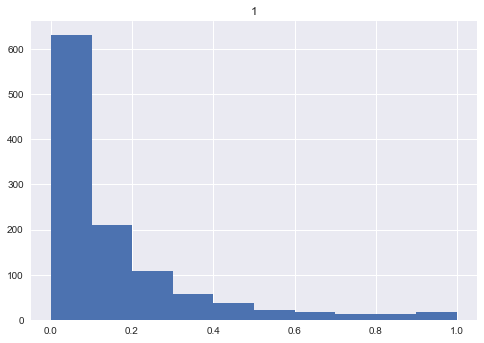

In [40]:
table[:1].T.hist()

It can be seen from the above histogram that most of the relevance scores lie in the 0 to 0.3 range. As these values dont provide useful information, we can use 0.3 as a suitable cutoff 

In [41]:
movie_tags = tagscore[tagscore.relevance > 0.3][['movieId', 'tagId','relevance']]

In [42]:
genome_tag.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [43]:
#Merging tag and movie names 

tags_to_movies = pd.merge(movie_tags, genome_tag, on='tagId', how='left')[['movieId', 'tagId','tag','relevance']]

In [44]:
tags_to_movies['tagId'] = tags_to_movies.tagId.astype(str)

In [45]:
tags_to_movies.head()

,movieId,tagId,tag,relevance
0,1,11,3d,0.57700
1,1,19,action,0.67050
2,1,21,adaptation,0.33025
3,1,29,adventure,0.89200
4,1,30,affectionate,0.67625


In [46]:
# Concatenating tags into movies dataset
def  concat_tags_of_movie (tags):
    tags_as_str = ','.join(set(tags))
    return tags_as_str



In [47]:
#Storing number of tags per movie
tags_per_movie  = tags_to_movies.groupby('movieId')['tag'].agg({
    'movie_tags': concat_tags_of_movie
}).reset_index()

In [48]:
#Getting average ratings for movies 
avg_ratings  = ratings.groupby('movieId')['rating'].agg({
    'rating_mean': 'mean',
    'rating_median': 'median',
    'num_ratings': 'size'
}).reset_index()

In [49]:
#Storing all movies with average of all ratings given to them by users
movies_with_ratings = pd.merge(movies, avg_ratings, how='left', on='movieId')

In [50]:
dataset = pd.merge(movies_with_ratings, tags_per_movie, how='left', on='movieId')

In [51]:
dataset.rename(columns={'median': 'median_rating', 'mean': 'mean_rating', 'tag': 'movie_tags'}, inplace=True)

In [91]:
dataset.head()

,movieId,title,num_ratings,rating_mean,rating_median,movie_tags
0,1,Toy Story (1995),49695.0,3.921240,4.0,"cute,highly quotable,enormously long battle sc..."
1,2,Jumanji (1995),22243.0,3.211977,3.0,"oscar (best supporting actress),big budget,und..."
2,3,Grumpier Old Men (1995),12735.0,3.151040,3.0,"family,happy ending,fish,wedding,silly,suprisi..."
3,4,Waiting to Exhale (1995),2756.0,2.861393,3.0,"love,cancer,based on a book,sweet,queer,romant..."
4,5,Father of the Bride Part II (1995),12161.0,3.064592,3.0,"bittersweet,big budget,family,cute,boston,crap..."


In [92]:
dataset.isnull().sum()

movieId              0
title                0
num_ratings        534
rating_mean        534
rating_median      534
movie_tags       16897
dtype: int64

In [93]:
#Dropping any null tags
final = dataset[dataset['num_ratings'].notnull()]

final = dataset[dataset['movie_tags'].notnull()]

final.isnull().sum()

movieId           0
title             0
num_ratings      11
rating_mean      11
rating_median    11
movie_tags        0
dtype: int64

In [94]:
final = final.dropna()

final.isnull().sum()

movieId          0
title            0
num_ratings      0
rating_mean      0
rating_median    0
movie_tags       0
dtype: int64

In [95]:
#Setting movieId as index of the dataframe

final.movieId = final.movieId.astype(str)

final = final.set_index('movieId')



In [96]:
#Creatin a new column called 'num_tags' that stores the number of tags per movie
final['num_tags'] = final['movie_tags'].str.split(',').apply(len)

In [97]:
#deleting unnecessary columns
del final['title']

del final['movie_tags']

In [107]:
# Building a K nearest neighbour model

# Recommend 20 similar items
engine = KNeighborsClassifier(n_neighbors=20)

# Training data points
data_points = final[['num_ratings', 'rating_mean','rating_median','num_tags']].values

#Training labels
labels = final.index.values

print("Data points: ")
print(data_points)
print("Labels: ")
print(labels)

engine.fit(data_points, labels)

Data points: 
[[  4.96950000e+04   3.92123956e+00   4.00000000e+00   1.79000000e+02]
 [  2.22430000e+04   3.21197680e+00   3.00000000e+00   1.11000000e+02]
 [  1.27350000e+04   3.15104044e+00   3.00000000e+00   5.70000000e+01]
 ..., 
 [  5.00000000e+00   2.50000000e+00   3.00000000e+00   7.00000000e+01]
 [  1.00000000e+00   3.50000000e+00   3.50000000e+00   1.58000000e+02]
 [  1.00000000e+00   3.50000000e+00   3.50000000e+00   1.95000000e+02]]
Labels: 
['1' '2' '3' ..., '131013' '131168' '131170']


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [115]:
# Enter movie ID to get a list of 20 recommended items

# User entered value
movie_id = '131170'

movie_data = [final.loc[movie_id].values]

recommended_movie = engine.kneighbors(X=movie_data, n_neighbors=20, return_distance=False)

# List of movie IDs 

movie_ids_list = []

for each in recommended_movie:
    movie_ids_list.append(final.iloc[each].index)

print("Recommended movies based on entered movieID: ")
print(movie_ids_list)

Recommended movies based on entered movieID: 
[Index([u'131170', u'127206', u'121231', u'107130', u'120478', u'116817',
       u'107953', u'110669', u'111764', u'114066', u'106102', u'114494',
       u'107057', u'117434', u'109687', u'127198', u'106749', u'118896',
       u'103849', u'126599'],
      dtype='object', name=u'movieId')]


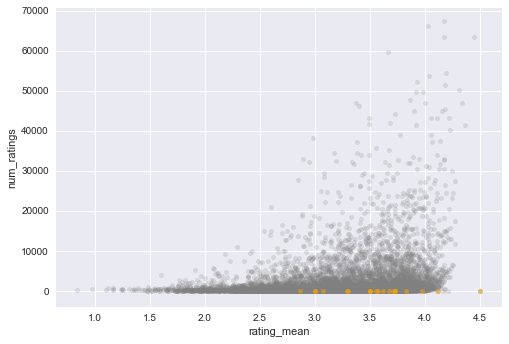

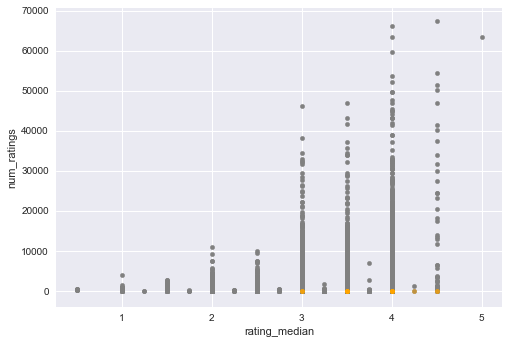

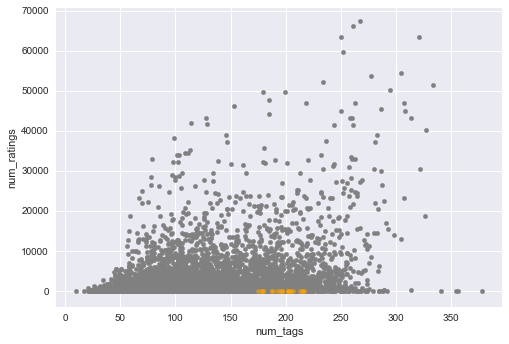

In [119]:
# Showing recommended movies in a scatter plot

ax = final.plot(kind='scatter', x='rating_mean', y='num_ratings', color='grey', alpha=0.20)
final.iloc[recommended_movie[0]].plot(kind='scatter', x='rating_mean', y='num_ratings',\
                                                   color='orange', alpha=0.5, ax=ax)

ax2 = final.plot(kind='scatter', x='rating_median', y='num_ratings', color='grey')
final.iloc[recommended_movie[0]].plot(kind='scatter', x='rating_median', y='num_ratings',\
                                                   color='orange', alpha=0.5, ax=ax2)


ax3 = final.plot(kind='scatter', x='num_tags', y='num_ratings', color='grey')
final.iloc[recommended_movie[0]].plot(kind='scatter', x='num_tags', y='num_ratings',\
                                                   color='orange', alpha=0.5, ax=ax3)


plt.show()

In [131]:
#resetting index of final df
final_df = final

final_df['movieId'] = df.movieId

In [132]:
final_df.head()

,movieId,num_ratings,rating_mean,rating_median,num_tags
0,27866,49695.0,3.921240,4.0,179
1,27866,22243.0,3.211977,3.0,111
2,27866,12735.0,3.151040,3.0,57
3,27866,2756.0,2.861393,3.0,57
4,27866,12161.0,3.064592,3.0,79


In [148]:
#Building a model based on k-means clustering model

features = final_df[['rating_mean','num_tags']]
def doKmeans(X, nclust=8):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(features, 2)
kmeans = pd.DataFrame(clust_labels)
features.insert((features.shape[1]),'kmeans',kmeans)

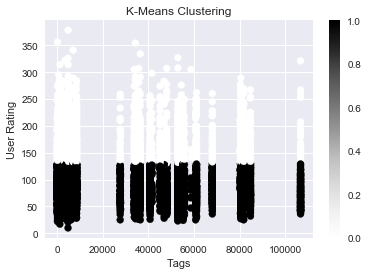

In [155]:
#Displaying results in a plot 
import itertools

fig = plt.figure()
ax = fig.add_subplot(111)

colors = itertools.cycle(["r", "b", "g"])

scatter = ax.scatter(final_df['movieId'],features['num_tags'],
                     c=kmeans[0])
ax.set_title('K-Means Clustering')
ax.set_xlabel('Tags')
ax.set_ylabel('User Rating')
   

plt.colorbar(scatter)